## BINING(DISCRETIZER)

## Apa Itu Bining Dicretizer

Binning (atau discretization) adalah proses mengubah fitur numerik kontinu menjadi fitur diskret (kategori) dengan membagi rentang nilainya menjadi beberapa bin (interval).

## Tujuan

menyederhanakan data, mengurangi noise, dan kadang meningkatkan performa model tertentu (seperti Naive Bayes).

## Jenis Bining

1. Equal Width Bining

  membagi seluruh rentang nilai menjadi bin dengan lebar sama

  contoh: jika panjang kelopak bervariasi dari 1.0-6.0, dan kita pakai 3 bin:
  - bin 1: 1.0-2.67
  - bin 2: 2.67-4.33
  - bin 3: 4.33-6.0

  kelebihan: mudah dan cepat
  kekurangan: tidak peduli distribusi data

2. Equal Frequency Binning (Quantile)

  setiap bin memiliki jumlah data yang hampir sama

  contoh: kita ingin membagi data menjadi 3 bin dan ada 150 data:
  - bin 1: 50 data dengan nilai terkecil
  - bin 2: 50 data dengan nilai tengah
  - bin 3: 50 data dengan nilai terbesar

  kelebihan: tiap bin berisi jumlah data sama
  kekurangan: bisa punya bin dengan range kecil/besar tidak konsisten

3. K-Means Binning (Clustering-based)

  alih-alih membagi berdasarkan nilai/jumlah, kita pakai k-means untuk menemukan pola alami dalam data

  kelebihan: menangkap pola alami dalam data
  kekurangan: lebih kompleks dan butuh pemrosesan lebih lama



CODE NYA

1. Menginstall beberapa library yang dibutuhkan, seperti:
- pymysql = library untuk connect dan melakukan query ke database MySQL dari Python.

- psycopg2-binary = library untuk connect dan melakukan query ke database postgresql

- pandas = library untuk manipulasi dan analisis data tabular, menyediakan struktur data frame yang lebih mudah digunakan

- SQLAlchemy = framework ORM dan API untuk berinteraksi dengan database tanpa harus menuliskan raw sql

- sckit-learn = library machine learning yang menyediakan model, algoritma, dan metric untuk training, testing dan evaluatin performa

- numpy = library untuk perhitungan matematika dan manipulasi array yang lebih efisien dan menjadi dasar dari pandas dan sckit-learn



In [2]:
!pip install pymysql
!pip install psycopg2-binary
!pip install pandas
!pip install SQLAlchemy pymysql
!pip install scikit-learn
!pip install numpy

2. Mengambil database  sql

In [3]:
import pymysql
import pandas as pd
from tabulate import tabulate

# --- Konfigurasi koneksi ---
MYSQL_HOST = "mysql-ce646e0-matakuliah.i.aivencloud.com"
MYSQL_PORT = 18376
MYSQL_DB = "defaultdb"
MYSQL_USER = "avnadmin"
MYSQL_PASS = "AVNS_ttJDVCcji3xAatQ6zvd"

try:
    # Membuka koneksi ke database
    conn = pymysql.connect(
        host=MYSQL_HOST,
        port=MYSQL_PORT,
        user=MYSQL_USER,
        password=MYSQL_PASS,
        database=MYSQL_DB,
        ssl={'ssl': {}},  # koneksi SSL untuk Aiven
    )
    cur = conn.cursor()

    # Menjalankan query
    cur.execute("SELECT * FROM defaultdb.irissql;")
    rows = cur.fetchall()

    # Ambil nama kolom
    col_names = [desc[0] for desc in cur.description]

    # Buat dua versi dataframe
    df_asli = pd.DataFrame(rows, columns=col_names)
    df = df_asli.copy()

    # Tampilkan data asli saja
    print(tabulate(df_asli, headers="keys", tablefmt="psql"))

except Exception as e:
    print("Error:", e)

finally:
    if cur:
        cur.close()
    if conn:
        conn.close()


+-----+------+-----------------+----------------+-----------------+----------------+-----------------+
|     |   id |   SepalLengthCm |   SepalWidthCm |   PetalLengthCm |   PetalWidthCm | species         |
|-----+------+-----------------+----------------+-----------------+----------------+-----------------|
|   0 |    1 |             5.1 |            3.5 |             1.4 |            0.2 | Iris-setosa     |
|   1 |    2 |             4.9 |            3   |             1.4 |            0.2 | Iris-setosa     |
|   2 |    3 |             4.7 |            3.2 |             1.3 |            0.2 | Iris-setosa     |
|   3 |    4 |             4.6 |            3.1 |             1.5 |            0.2 | Iris-setosa     |
|   4 |    5 |             5   |            3.6 |             1.4 |            0.2 | Iris-setosa     |
|   5 |    6 |             5.4 |            3.9 |             1.7 |            0.4 | Iris-setosa     |
|   6 |    7 |             4.6 |            3.4 |             1.4 |      

3. Memisahkan sendiri setiap kolom nya dari tabel dab ubah data numeriknya menjadi kategorikal

In [4]:
pd.set_option('display.max_rows', None)

print(df[['SepalLengthCm']])

    SepalLengthCm
0            5.10
1            4.90
2            4.70
3            4.60
4            5.00
5            5.40
6            4.60
7            5.00
8            4.40
9            4.90
10           5.40
11           4.80
12           4.80
13           4.30
14           5.80
15           5.70
16           5.40
17           5.10
18           5.70
19           5.10
20           5.40
21           5.10
22           4.60
23           5.10
24           4.80
25           5.00
26           5.00
27           5.20
28           5.20
29           4.70
30           4.80
31           5.40
32           5.20
33           5.50
34           4.90
35           5.00
36           5.50
37           4.90
38           4.40
39           5.10
40           5.00
41           4.50
42           4.40
43           5.00
44           5.10
45           4.80
46           5.10
47           4.60
48           5.30
49           5.00
50           7.00
51           6.40
52           6.90
53           5.50
54        

In [5]:
from sklearn.cluster import KMeans  # Mengimpor KMeans dari scikit-learn, algoritma untuk clustering
import numpy as np  # Mengimpor NumPy, berguna untuk perhitungan matematika dan array

# Pastikan kolom SepalLengthCm bertipe float
# (Ini penting karena KMeans membutuhkan tipe numerik)
df['SepalLengthCm'] = df['SepalLengthCm'].astype(float)

# Membuat sebuah object KMeans dengan 4 clusters dan sebuah seed untuk reproducibility
# n_clusters = 4 -> mencari 4 kelompok
# random_state = 42 -> agar hasilnya dapat direproduksi
kmeans = KMeans(n_clusters=4, random_state=42)

# Melatih KMeans dan mendapatkan label clusters untuk masing-masing baris
# Di sini yang diberlakukan untuk clustering hanya satu kolom saja (SepalLengthCm)
clusters = kmeans.fit_predict(df[['SepalLengthCm']])

# Mengambil pusat clusters (centroid) dan kemudian diberi peringkat
# Dalam hal ini, diberi peringkat dari yang terkecil ke terbesar
# sehingga nanti diberi label A, B, C, D sesuai urutan ukuran centroid
cluster_centers = kmeans.cluster_centers_.flatten()
sorted_indices = np.argsort(cluster_centers)

# Membuat mapping dari indeks clusters yang diberika KMeans ke huruf
# A, B, C, D sesuai urutan ukuran centroid
# Misalnya centroid yang paling kecil diberi A, yang lebih besar diberi B, dan seterusnya
cluster_map = {old: chr(65+i) for i, old in enumerate(sorted_indices)}

# Mengganti label clusters yang diberika KMeans dengan huruf A, B, C, D sesuai mapping yang dibuat
# Dengan cara melakukan perulangan pada masing-masing clusters
df['SepalLengthCm'] = [cluster_map[c] for c in clusters]

# Cek hasilnya
# Dengan menampilkan DataFrame yang hanya punya kolom SepalLengthCm
print(df[['SepalLengthCm']])  # Tiap baris akan diberi label huruf sesuai kelompoknya


    SepalLengthCm
0               A
1               A
2               A
3               A
4               A
5               B
6               A
7               A
8               A
9               A
10              B
11              A
12              A
13              A
14              B
15              B
16              B
17              A
18              B
19              A
20              B
21              A
22              A
23              A
24              A
25              A
26              A
27              A
28              A
29              A
30              A
31              B
32              A
33              B
34              A
35              A
36              B
37              A
38              A
39              A
40              A
41              A
42              A
43              A
44              A
45              A
46              A
47              A
48              B
49              A
50              D
51              C
52              D
53              B
54        

In [6]:
print(df)

      id SepalLengthCm SepalWidthCm PetalLengthCm PetalWidthCm  \
0      1             A         3.50          1.40         0.20   
1      2             A         3.00          1.40         0.20   
2      3             A         3.20          1.30         0.20   
3      4             A         3.10          1.50         0.20   
4      5             A         3.60          1.40         0.20   
5      6             B         3.90          1.70         0.40   
6      7             A         3.40          1.40         0.30   
7      8             A         3.40          1.50         0.20   
8      9             A         2.90          1.40         0.20   
9     10             A         3.10          1.50         0.10   
10    11             B         3.70          1.50         0.20   
11    12             A         3.40          1.60         0.20   
12    13             A         3.00          1.40         0.10   
13    14             A         3.00          1.10         0.10   
14    15  

In [7]:
pd.set_option('display.max_rows', None)

print(df[['SepalWidthCm']])

    SepalWidthCm
0           3.50
1           3.00
2           3.20
3           3.10
4           3.60
5           3.90
6           3.40
7           3.40
8           2.90
9           3.10
10          3.70
11          3.40
12          3.00
13          3.00
14          4.00
15          4.40
16          3.90
17          3.50
18          3.80
19          3.80
20          3.40
21          3.70
22          3.60
23          3.30
24          3.40
25          3.00
26          3.40
27          3.50
28          3.40
29          3.20
30          3.10
31          3.40
32          4.10
33          4.20
34          3.10
35          3.20
36          3.50
37          3.10
38          3.00
39          3.40
40          3.50
41          2.30
42          3.20
43          3.50
44          3.80
45          3.00
46          3.80
47          3.20
48          3.70
49          3.30
50          3.20
51          3.20
52          3.10
53          2.30
54          2.80
55          2.80
56          3.30
57          2.

In [8]:
from sklearn.cluster import KMeans
import numpy as np

# Pastikan kolom numerik
df['SepalWidthCm'] = df['SepalWidthCm'].astype(float)

# Terapkan KMeans dengan 3 cluster
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(df[['SepalWidthCm']])

# Urutkan cluster berdasarkan rata-rata sepal width
cluster_centers = kmeans.cluster_centers_.flatten()
sorted_indices = np.argsort(cluster_centers)
cluster_map = {old: chr(65+i) for i, old in enumerate(sorted_indices)}  # A, B, C

# Ganti label cluster dengan huruf A–C
df['SepalWidthCm'] = [cluster_map[c] for c in clusters]

# Cek hasil
print(df[['SepalWidthCm']])


    SepalWidthCm
0              C
1              B
2              B
3              B
4              C
5              C
6              C
7              C
8              B
9              B
10             C
11             C
12             B
13             B
14             C
15             C
16             C
17             C
18             C
19             C
20             C
21             C
22             C
23             C
24             C
25             B
26             C
27             C
28             C
29             B
30             B
31             C
32             C
33             C
34             B
35             B
36             C
37             B
38             B
39             C
40             C
41             A
42             B
43             C
44             C
45             B
46             C
47             B
48             C
49             C
50             B
51             B
52             B
53             A
54             B
55             B
56             C
57            

In [9]:
print(df)

      id SepalLengthCm SepalWidthCm PetalLengthCm PetalWidthCm  \
0      1             A            C          1.40         0.20   
1      2             A            B          1.40         0.20   
2      3             A            B          1.30         0.20   
3      4             A            B          1.50         0.20   
4      5             A            C          1.40         0.20   
5      6             B            C          1.70         0.40   
6      7             A            C          1.40         0.30   
7      8             A            C          1.50         0.20   
8      9             A            B          1.40         0.20   
9     10             A            B          1.50         0.10   
10    11             B            C          1.50         0.20   
11    12             A            C          1.60         0.20   
12    13             A            B          1.40         0.10   
13    14             A            B          1.10         0.10   
14    15  

In [10]:
pd.set_option('display.max_rows', None)

print(df[['PetalLengthCm']])

    PetalLengthCm
0            1.40
1            1.40
2            1.30
3            1.50
4            1.40
5            1.70
6            1.40
7            1.50
8            1.40
9            1.50
10           1.50
11           1.60
12           1.40
13           1.10
14           1.20
15           1.50
16           1.30
17           1.40
18           1.70
19           1.50
20           1.70
21           1.50
22           1.00
23           1.70
24           1.90
25           1.60
26           1.60
27           1.50
28           1.40
29           1.60
30           1.60
31           1.50
32           1.50
33           1.40
34           1.50
35           1.20
36           1.30
37           1.50
38           1.30
39           1.50
40           1.30
41           1.30
42           1.30
43           1.60
44           1.90
45           1.40
46           1.60
47           1.40
48           1.50
49           1.40
50           4.70
51           4.50
52           4.90
53           4.00
54        

In [11]:
from sklearn.cluster import KMeans
import numpy as np

# Pastikan kolom numerik
df['PetalLengthCm'] = df['PetalLengthCm'].astype(float)

# Terapkan KMeans dengan 4 cluster
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(df[['PetalLengthCm']])

# Urutkan cluster berdasarkan rata-rata sepal width
cluster_centers = kmeans.cluster_centers_.flatten()
sorted_indices = np.argsort(cluster_centers)
cluster_map = {old: chr(65+i) for i, old in enumerate(sorted_indices)}  # A, B, C, D

# Ganti label cluster dengan huruf A–D
df['PetalLengthCm'] = [cluster_map[c] for c in clusters]

# Cek hasil
print(df[['PetalLengthCm']])


    PetalLengthCm
0               A
1               A
2               A
3               A
4               A
5               A
6               A
7               A
8               A
9               A
10              A
11              A
12              A
13              A
14              A
15              A
16              A
17              A
18              A
19              A
20              A
21              A
22              A
23              A
24              A
25              A
26              A
27              A
28              A
29              A
30              A
31              A
32              A
33              A
34              A
35              A
36              A
37              A
38              A
39              A
40              A
41              A
42              A
43              A
44              A
45              A
46              A
47              A
48              A
49              A
50              C
51              C
52              C
53              B
54        

In [12]:
print(df)

      id SepalLengthCm SepalWidthCm PetalLengthCm PetalWidthCm  \
0      1             A            C             A         0.20   
1      2             A            B             A         0.20   
2      3             A            B             A         0.20   
3      4             A            B             A         0.20   
4      5             A            C             A         0.20   
5      6             B            C             A         0.40   
6      7             A            C             A         0.30   
7      8             A            C             A         0.20   
8      9             A            B             A         0.20   
9     10             A            B             A         0.10   
10    11             B            C             A         0.20   
11    12             A            C             A         0.20   
12    13             A            B             A         0.10   
13    14             A            B             A         0.10   
14    15  

In [13]:
pd.set_option('display.max_rows', None)

print(df[['PetalWidthCm']])

    PetalWidthCm
0           0.20
1           0.20
2           0.20
3           0.20
4           0.20
5           0.40
6           0.30
7           0.20
8           0.20
9           0.10
10          0.20
11          0.20
12          0.10
13          0.10
14          0.20
15          0.40
16          0.40
17          0.30
18          0.30
19          0.30
20          0.20
21          0.40
22          0.20
23          0.50
24          0.20
25          0.20
26          0.40
27          0.20
28          0.20
29          0.20
30          0.20
31          0.40
32          0.10
33          0.20
34          0.10
35          0.20
36          0.20
37          0.10
38          0.20
39          0.20
40          0.30
41          0.30
42          0.20
43          0.60
44          0.40
45          0.30
46          0.20
47          0.20
48          0.20
49          0.20
50          1.40
51          1.50
52          1.50
53          1.30
54          1.50
55          1.30
56          1.60
57          1.

In [14]:
from sklearn.cluster import KMeans
import numpy as np

# Pastikan kolom numerik
df['PetalWidthCm'] = df['PetalWidthCm'].astype(float)

# Terapkan KMeans dengan 3 cluster
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(df[['PetalWidthCm']])

# Urutkan cluster berdasarkan rata-rata sepal width
cluster_centers = kmeans.cluster_centers_.flatten()
sorted_indices = np.argsort(cluster_centers)
cluster_map = {old: chr(65+i) for i, old in enumerate(sorted_indices)}  # A, B, C

# Ganti label cluster dengan huruf A–C
df['PetalWidthCm'] = [cluster_map[c] for c in clusters]

# Cek hasil
print(df[['PetalWidthCm']])


    PetalWidthCm
0              A
1              A
2              A
3              A
4              A
5              A
6              A
7              A
8              A
9              A
10             A
11             A
12             A
13             A
14             A
15             A
16             A
17             A
18             A
19             A
20             A
21             A
22             A
23             A
24             A
25             A
26             A
27             A
28             A
29             A
30             A
31             A
32             A
33             A
34             A
35             A
36             A
37             A
38             A
39             A
40             A
41             A
42             A
43             A
44             A
45             A
46             A
47             A
48             A
49             A
50             B
51             B
52             B
53             B
54             B
55             B
56             B
57            

4. Gabungkan lagi semua kolom yang datanya sudah berubah menjadi kategorikal menjadi satu table

In [15]:
print(df)

      id SepalLengthCm SepalWidthCm PetalLengthCm PetalWidthCm  \
0      1             A            C             A            A   
1      2             A            B             A            A   
2      3             A            B             A            A   
3      4             A            B             A            A   
4      5             A            C             A            A   
5      6             B            C             A            A   
6      7             A            C             A            A   
7      8             A            C             A            A   
8      9             A            B             A            A   
9     10             A            B             A            A   
10    11             B            C             A            A   
11    12             A            C             A            A   
12    13             A            B             A            A   
13    14             A            B             A            A   
14    15  

5. klasifikasi data yang sudah diubah menjadi kategorikal menggunakan model Naive Bayes.

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import CategoricalNB
from sklearn.metrics import accuracy_score, classification_report

# Ubah kategori huruf ke angka karena CategoricalNB butuh numerik
X = df[['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']].apply(lambda col: col.astype('category').cat.codes)
y = df['species'].astype('category').cat.codes  # label juga ubah ke angka

# Split data latih dan uji
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Buat model dan latih
model = CategoricalNB()
model.fit(X_train, y_train)

# Prediksi dan evaluasi
y_pred = model.predict(X_test)
print(f"Akurasi: {accuracy_score(y_test, y_pred) * 100:.2f}%")
print("Laporan klasifikasi:\n", classification_report(y_test, y_pred))

Akurasi: 100.00%
Laporan klasifikasi:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



6. klasifikasi data numerik menggunakan model Naive Bayes.

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

# 1. Ambil fitur numerik dan label
fitur = ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']
X_ori = df_asli[fitur].astype(float)  # pastikan numerik
y_ori = df_asli['species']

# 2. Encode label jadi angka
le = LabelEncoder()
y_encoded = le.fit_transform(y_ori)

# 3. Split data latih dan uji (30% uji)
X_train, X_test, y_train, y_test = train_test_split(X_ori, y_encoded, test_size=0.3, random_state=42)

# 4. Latih model Naive Bayes
model_nb = GaussianNB()
model_nb.fit(X_train, y_train)

# 5. Prediksi
y_pred = model_nb.predict(X_test)

# 6. Evaluasi
print(f"Akurasi: {accuracy_score(y_test, y_pred) * 100:.2f}%")
print("Laporan klasifikasi:")
print(classification_report(y_test, y_pred, target_names=le.classes_))


Akurasi: 97.78%
Laporan klasifikasi:
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        19
Iris-versicolor       1.00      0.92      0.96        13
 Iris-virginica       0.93      1.00      0.96        13

       accuracy                           0.98        45
      macro avg       0.98      0.97      0.97        45
   weighted avg       0.98      0.98      0.98        45



7. Decision tree untuk data kategorikal

Akurasi : 100.0 %
Laporan klasifikasi:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



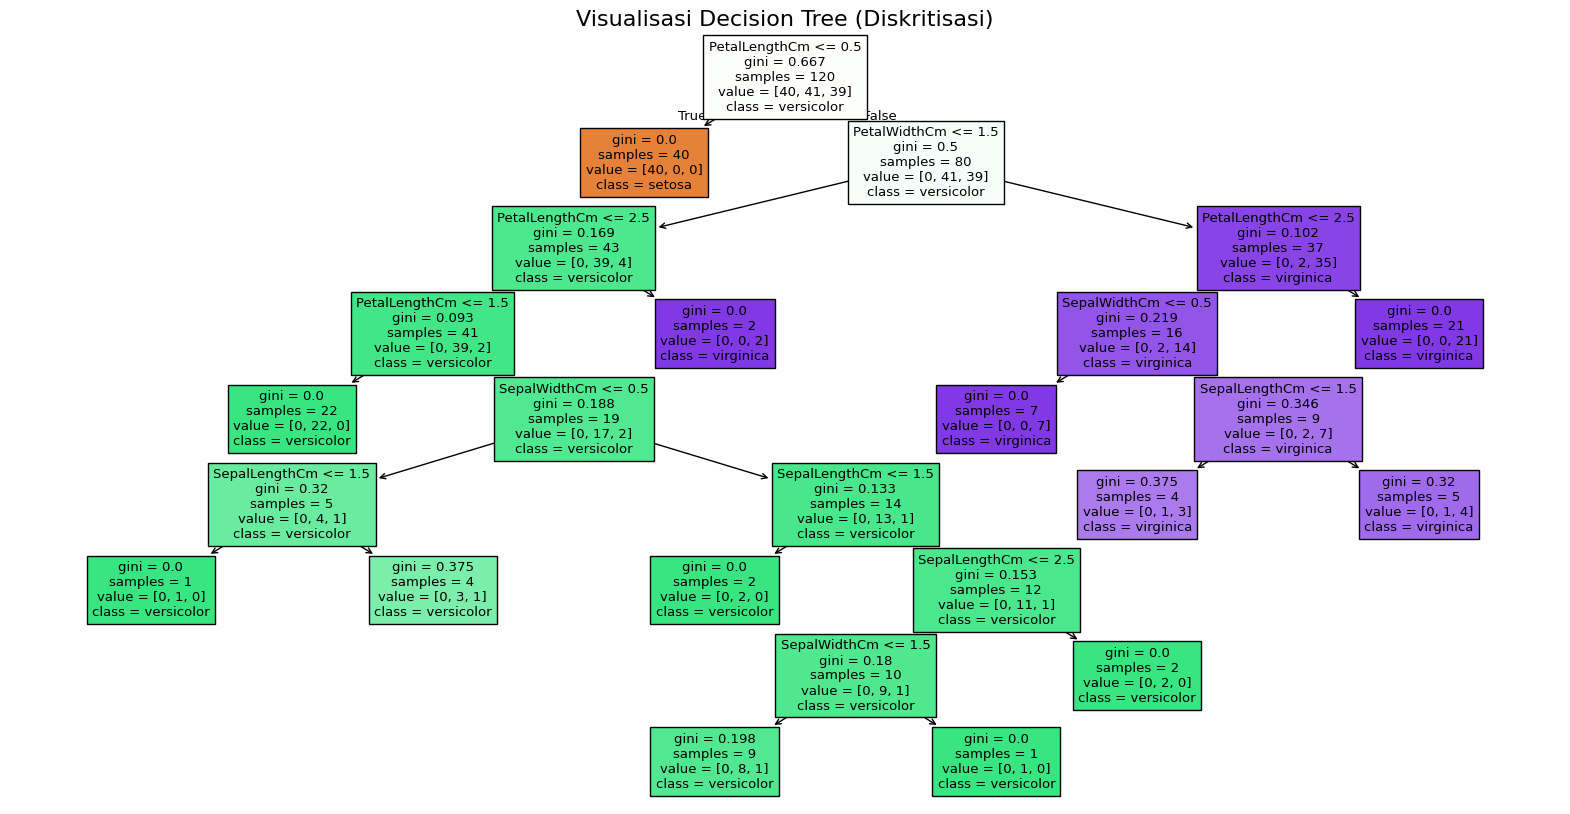

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

# Encode fitur dan label
X = df.copy()
X = X.copy()
X_features = ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']

# Mengkonversi huruf (A, B, C, D) menjadi nomor
X[X_features] = X[X_features].apply(lambda col: col.astype('category').cat.codes)

# Mengkonversi label species juga
y = X['species'].astype('category').cat.codes

# Menghapus kolom yang bukan fitur
X = X[X_features]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

# Prediksi
y_pred = dt_model.predict(X_test)

# Evaluasi
print("Akurasi :", accuracy_score(y_test, y_pred) * 100, "%")
print("Laporan klasifikasi:")
print(classification_report(y_test, y_pred))

# Visualisasi Decision Tree
plt.figure(figsize=(20, 10))
plot_tree(dt_model, feature_names=X_features, class_names=['setosa', 'versicolor', 'virginica'], filled=True)
plt.title("Visualisasi Decision Tree (Diskritisasi)", fontsize=16)
plt.show()


8. Decision tree untuk data numerik

Akurasi: 100.00%
Laporan klasifikasi:
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       1.00      1.00      1.00         9
 Iris-virginica       1.00      1.00      1.00        11

       accuracy                           1.00        30
      macro avg       1.00      1.00      1.00        30
   weighted avg       1.00      1.00      1.00        30



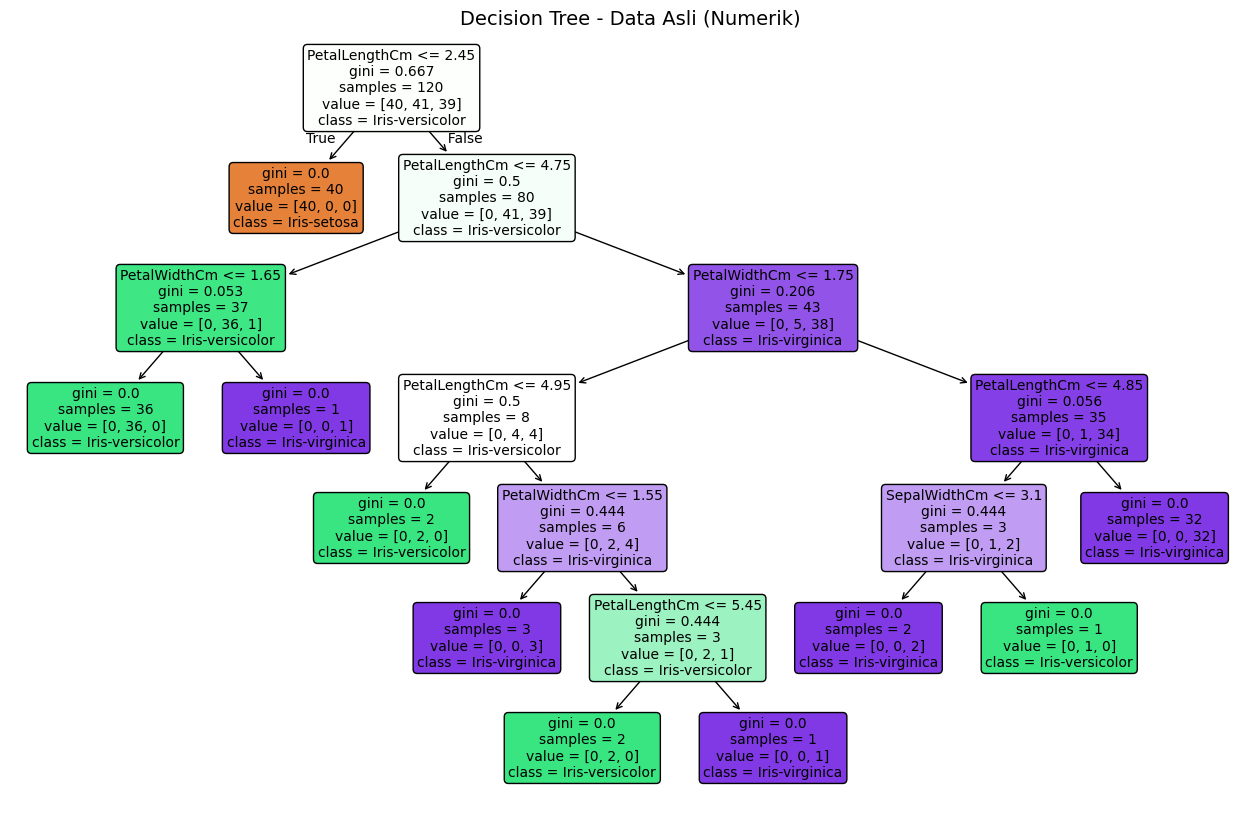

In [19]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

# Asumsikan df_asli sudah ada dan kolom 'species' adalah label
# Menghapus kolom 'id' yang bukan fitur dan label
X_ori = df_asli.drop(columns=['species', 'id'])
y_ori = df_asli['species']

# Mengkonversi tipe data fitur menjadi float
X_ori = X_ori.astype(float)

# Split data menjadi training dan testing (20% testing)
X_train, X_test, y_train, y_test = train_test_split(X_ori, y_ori, test_size=0.2, random_state=42)

# Inisialisasi dan melatih model Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

# Melakukan prediksi
y_pred = dt_model.predict(X_test)

# Menghitung akurasi dan menampilkannya sebagai persen
accuracy = accuracy_score(y_test, y_pred) * 100
print(f"Akurasi: {accuracy:.2f}%")  # tampil 2 decimal

# Mengirim laporan klasifikasi yang lebih rinci
print("Laporan klasifikasi:")
print(classification_report(y_test, y_pred))

# Visualisasi Decision Tree
plt.figure(figsize=(16, 10))
plot_tree(
    dt_model,
    feature_names=X_ori.columns,
    class_names=dt_model.classes_,
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Decision Tree - Data Asli (Numerik)", fontsize=14)
plt.show()
